In [1]:
### IGNORE: unless you have a gpu and receive the error noted

# source: https://www.tensorflow.org/guide/gpu 
# code to avoid "Attempting to perform BLAS operation using StreamExecutor without BLAS support" error 

import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Memory growth must be set before GPUs have been initialized
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)

Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


## Convolutions in Keras

The code below will allow you to play with a single convolutional layer in Keras. Take a look at the documentation for the [Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/) layer, which is also where the original code came from. 

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D

In [3]:
input_shape = (4, 28, 28, 3)

x = tf.random.normal(input_shape)

y = Conv2D(filters=2, 
           kernel_size=(3, 3), 
           strides=1, 
           padding='valid', 
           input_shape=(None, 28, 28, 3))(x)

Here is a brief explanation of the above code: 

<img src="Convolution_notebook-2.jpg" width=600 align="center">

In [4]:
y.shape

TensorShape([4, 26, 26, 2])

In [5]:
y[0,:,:,:]

<tf.Tensor: shape=(26, 26, 2), dtype=float32, numpy=
array([[[ 0.07122778,  0.3587284 ],
        [-0.1659941 , -0.13920677],
        [-1.2554857 ,  0.19189577],
        ...,
        [-0.64094514, -0.12386996],
        [ 0.33015925, -1.098136  ],
        [-1.7852827 , -2.0306382 ]],

       [[-0.11142711, -0.23239742],
        [-0.33728555, -0.06348665],
        [-0.4170758 ,  0.6994112 ],
        ...,
        [ 2.2738678 ,  1.7293322 ],
        [-1.4494283 , -1.2094704 ],
        [ 0.4458612 , -1.534751  ]],

       [[-1.0277263 , -0.42841095],
        [-0.48153153,  0.6166767 ],
        [-0.337612  , -0.65084577],
        ...,
        [ 0.68965274, -0.6067686 ],
        [-0.08402138,  1.6003183 ],
        [-2.0023599 ,  1.6262167 ]],

       ...,

       [[ 0.44174492, -1.0078942 ],
        [ 0.65912354, -0.37654933],
        [-0.5667208 , -0.4324725 ],
        ...,
        [ 1.4064775 ,  0.9509742 ],
        [-0.57978445,  1.5211177 ],
        [-0.909939  ,  1.5562384 ]],

       [[-

<img src="Convolution_notebook-1.jpg" width=600 align="center">

## MNIST Revisited

Let's now revisit MNIST. Knowing that the data contains 2-dimensional images of handwritten digits, we should be able to apply what we've learned about convolutions. Thus, in this section, we will create a convolutional neural network (CNN or convnet) for this data set.

In [19]:
from tensorflow.keras.datasets import mnist
import numpy as np 

(train_data, train_labels), (test_data, test_labels) = mnist.load_data()

We are going to use a **validation set** to monitor our training progress. We can also use this validation set for *hyperparameter tuning*. Remember, using the validation set allows us to keep the *test set* to gauge how well our final model should do in the real world; that is, the final model only sees the test data once.

In [20]:
# Use the first 10,000 samples of our training data as our validation set
val_data = train_data[:10000]
val_labels = train_labels[:10000]

# Use the remainder of the original training data for actual training
partial_train_data = train_data[10000:]
partial_train_labels = train_labels[10000:]

In [21]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [22]:
# Scale the pixel values so they lie in the range of 0-1
partial_train_data = partial_train_data / 255.
val_data = val_data / 255.
test_data = test_data /255.

Note that our data currently has 3 dimensions: `(samples, height, width)`. 

In [23]:
print(partial_train_data.shape)
print(val_data.shape)
print(test_data.shape)

(50000, 28, 28)
(10000, 28, 28)
(10000, 28, 28)


Our convolutional neural network will expect 4-dimensional data: `(batch_size, height, width, channels)`. Note that depending on how you decide to update the parameters of the network, `batch_size` could equal the number of `samples` (as in *batch gradient descent*), or it could equal a single sample (as in *stochastic gradient descent*, or it can equal the batch size (as in *mini-batch gradient descent*). 

We can use a NumPy function to add this dimension. 

In [24]:
partial_train_data = np.expand_dims(partial_train_data, axis=3)
val_data = np.expand_dims(val_data, axis=3)
test_data = np.expand_dims(test_data, axis=3)

In [25]:
print(partial_train_data.shape)
print(val_data.shape)
print(test_data.shape)

(50000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)


Note how a fourth dimension was added to our data. This dimension corresponds to the number of channels in our input data. Here it is 1, since the images are all greyscale. It would be 3 if the images were RGB. Also note, that the convention here is *channels last*, as opposed to *channels first*.

We need to convert our label data to the correct format. 

In [26]:
partial_train_labels[:5]

array([3, 8, 7, 9, 9], dtype=uint8)

In [27]:
from tensorflow.keras.utils import to_categorical

partial_train_labels = to_categorical(partial_train_labels)
val_labels = to_categorical(val_labels)
test_labels = to_categorical(test_labels)

In [28]:
partial_train_labels[:5]

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

<img src="target_encoding.jpg" width=600 align="center">

We will now import the necessary modules for building our convolutional neural network. Since we are using Keras's sequential API we need to import the `Sequential` module. The remaining 3 imports will help us build the layers of our CNN. `Conv2D` creates the convolutional layers we have been discussing in the lectures. `Flatten` is used to create a 1 dimensional vector so we can feed the output of our convolutional layers to the fully-connected layers. We used NumPy's `reshape` function to do this flattening in Lab 1. And the `Dense` layer is the same as what we used in Lab 1. 

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

We are going to use a slightly different approach to building our network than we did in Lab 1. Here we will directly add a *list of layers* to the `Sequential()` object. That is, we put all our layers inside square brackets `[...]` and put this inside the `Sequential( [...] )` object to create our model. In Lab 1 we used the `.add()` method to add individual layers to our `Sequential()` object that we initialized without any layers. 

In [30]:
model = Sequential([
    Conv2D(filters=32, 
           kernel_size=(3, 3), 
           strides=1, 
           padding='same', 
           activation='relu',
           input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, 
           kernel_size=(3, 3), 
           strides=1, 
           padding='same', 
          activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

It is often helpful to see the tensor shapes and number of parameters per layer. We can get this information by using the `.summary()` method. 

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 128)               4

We are still tackling the same type of problem (multi-class classification) so the same loss and metrics will work for us here. The optimizer `rmsprop` is the same as we used before and can be taken as the default method (or recipe) to try out for updating the model parameters.

In [32]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

We now fit our model to the remaining training data (the original training data minus the validation data). You will now see that *loss* and *accuracy* get updated for each batch of images (here set to 256) but the *validation loss* and *validation accuracy* get updated after each *epoch*. Note that the *validation data* is not being used to train the model. Each batch of the training data is used to update the parameters and then, once we have gone through all of the samples in our training data (that is, all the samples in `partial_train_data`) the model is used to make predictions for the validation set. From those predictions the validation loss and accuracy are calculated. 

Each epoch of training should take 30-50s to complete. 

In [33]:
history = model.fit(partial_train_data, 
                    partial_train_labels, 
                    epochs=10, 
                    batch_size=256, 
                    validation_data=(val_data, val_labels),
                    verbose=1)

Epoch 1/10
196/196 [==============================] - 5s 10ms/step - loss: 0.3759 - accuracy: 0.8833 - val_loss: 0.1181 - val_accuracy: 0.9651
Epoch 2/10
196/196 [==============================] - 2s 8ms/step - loss: 0.1094 - accuracy: 0.9667 - val_loss: 0.0769 - val_accuracy: 0.9775
Epoch 3/10
196/196 [==============================] - 2s 8ms/step - loss: 0.0768 - accuracy: 0.9768 - val_loss: 0.0732 - val_accuracy: 0.9786
Epoch 4/10
196/196 [==============================] - 2s 8ms/step - loss: 0.0585 - accuracy: 0.9824 - val_loss: 0.0484 - val_accuracy: 0.9869
Epoch 5/10
196/196 [==============================] - 2s 8ms/step - loss: 0.0507 - accuracy: 0.9848 - val_loss: 0.0479 - val_accuracy: 0.9854
Epoch 6/10
196/196 [==============================] - 2s 8ms/step - loss: 0.0438 - accuracy: 0.9869 - val_loss: 0.0463 - val_accuracy: 0.9864
Epoch 7/10
196/196 [==============================] - 2s 8ms/step - loss: 0.0373 - accuracy: 0.9885 - val_loss: 0.0425 - val_accuracy: 0.9876
Epoch

The values for the training loss and accuracy, as well as the validation loss and accuracy, are stored in the `history` variable. You can see the structure of the dictionary that stores this information as follows:

In [34]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

We will now use this information to visualize the progress our network makes on the loss and accuracy as the number of epochs increases. 

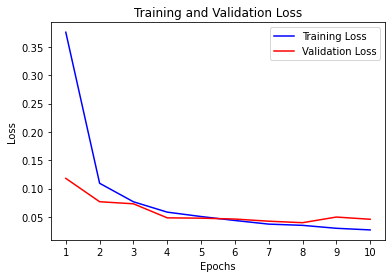

In [35]:
import matplotlib.pyplot as plt  # needed to create our plot

history_dict = history.history # the dictionary that has the information on loss and accuracy per epoch

loss_values = history_dict['loss']   # training loss
val_loss_values = history_dict['val_loss'] # validation loss

epochs = range(1, len(loss_values)+1)  #creates list of integers to match the number of epochs of training

# code to plot the results
plt.plot(epochs, loss_values, 'b', label="Training Loss")
plt.plot(epochs, val_loss_values, 'r', label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Loss")
plt.legend()
plt.show()

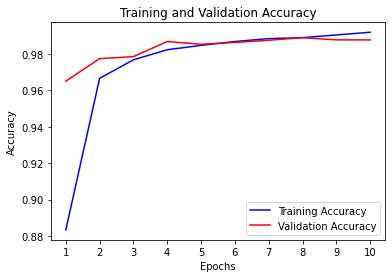

In [36]:
# As above, but this time we want to visualize the training and validation accuracy
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc_values, 'b', label="Training Accuracy")
plt.plot(epochs, val_acc_values, 'r', label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Accuracy")
plt.legend()
plt.show()